In [1]:
library(tidyverse)
library(reshape2)

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats

Attaching package: ‘reshape2’

The following object is masked from ‘package:tidyr’:

    smiths



# Machine learning tutorial: R users group edition

We are using the data from chapter 2 of this book: https://github.com/ageron/handson-ml

Here I have 'translated' (and heavily abridged) the code from python into R so that it can be used as a good intro example for how to implement some machine learning algorithms. The workflow isn't exactly the same as the book but the data arrives cleaned at roughly the same point. 

I've chosen this dataset because:
1. It is freely avaliable online so we won't get sued.
2. It is 'medium' sized. Not small enough to feel overly toyish, but not so big as to be cumbersome.
3. There are a reasonable number of predictor columns, so it isn't too much to take in and understand what they all mean.

The columns are as follows, their names are pretty self explanitory:

longitude

latitude

housing_median_age

total_rooms

total_bedrooms

population

households

median_income

median_house_value

ocean_proximity

Each row pertains to a group of houses (I forget if this is by block or postal code but the important bit is they are medians because it is a bunch of houses in close proximity grouped together).

# GOAL: Make a model to predict median house value for a district based on the other data we are given.

## Step 1. Load in the data.

If you missed the email link, download 'housing.csv' from here:
https://github.com/ageron/handson-ml/tree/master/datasets/housing

Then adjust the following code to your directory of choice.

In [2]:
housing = read.csv('/Users/Cam/Desktop/Code/hands_on_maching_learning/supplemental/datasets/housing/housing.csv')

First thing I always do is use the head command to make sure the data isn't weird and looks how I expected.

In [3]:
head(housing)

longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
-122.23,37.88,41,880,129,322,126,8.3252,452600,NEAR BAY
-122.22,37.86,21,7099,1106,2401,1138,8.3014,358500,NEAR BAY
-122.24,37.85,52,1467,190,496,177,7.2574,352100,NEAR BAY
-122.25,37.85,52,1274,235,558,219,5.6431,341300,NEAR BAY
-122.25,37.85,52,1627,280,565,259,3.8462,342200,NEAR BAY
-122.25,37.85,52,919,213,413,193,4.0368,269700,NEAR BAY


Next I always call summary, just to see if the #s are #s and the categoricals are categoricals.

In [4]:
summary(housing)

   longitude         latitude     housing_median_age  total_rooms   
 Min.   :-124.3   Min.   :32.54   Min.   : 1.00      Min.   :    2  
 1st Qu.:-121.8   1st Qu.:33.93   1st Qu.:18.00      1st Qu.: 1448  
 Median :-118.5   Median :34.26   Median :29.00      Median : 2127  
 Mean   :-119.6   Mean   :35.63   Mean   :28.64      Mean   : 2636  
 3rd Qu.:-118.0   3rd Qu.:37.71   3rd Qu.:37.00      3rd Qu.: 3148  
 Max.   :-114.3   Max.   :41.95   Max.   :52.00      Max.   :39320  
                                                                    
 total_bedrooms     population      households     median_income    
 Min.   :   1.0   Min.   :    3   Min.   :   1.0   Min.   : 0.4999  
 1st Qu.: 296.0   1st Qu.:  787   1st Qu.: 280.0   1st Qu.: 2.5634  
 Median : 435.0   Median : 1166   Median : 409.0   Median : 3.5348  
 Mean   : 537.9   Mean   : 1425   Mean   : 499.5   Mean   : 3.8707  
 3rd Qu.: 647.0   3rd Qu.: 1725   3rd Qu.: 605.0   3rd Qu.: 4.7432  
 Max.   :6445.0   Max.   :35682   

### Begin making a cleaning to do list
So from that summary we can see a few things we need to do before actually running algorithms.

1. NA's in total_bedrooms need to be addressed. These must be given a value
2. We will split the ocean_proximity into binary columns. Most machine learning algorithms in R can handle categoricals in a single column, but we will cater to the lowest common denominator and do the splitting.
3. Make the total_bedrooms and total_rooms into a mean_number_bedrooms and mean_number_rooms columns as there are likely more accurate depections of the houses in a given group.


Lets take a gander at the variables

In [7]:
colnames(housing)

[1] "longitude"          "latitude"           "housing_median_age"
 [4] "total_rooms"        "total_bedrooms"     "population"        
 [7] "households"         "median_income"      "median_house_value"
[10] "ocean_proximity"

In [8]:
par(mfrow=c(2,5))

Using ocean_proximity as id variables
Warning message:
“Removed 207 rows containing non-finite values (stat_bin).”

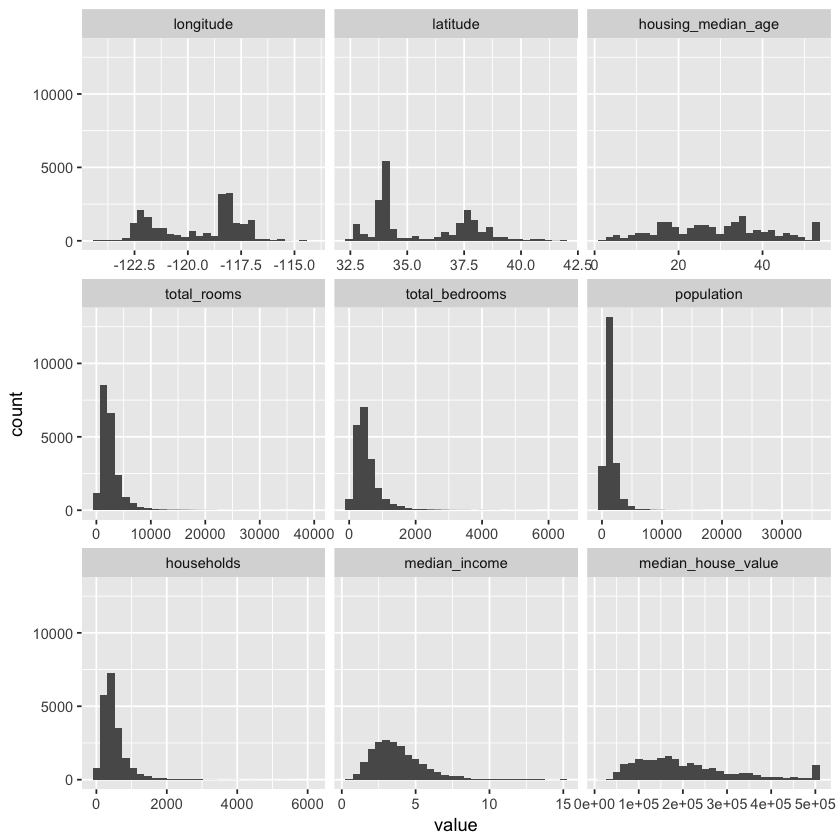

In [9]:
ggplot(data = melt(housing), mapping = aes(x = value)) + 
    geom_histogram(bins = 30) + facet_wrap(~variable, scales = 'free_x')

Things I see from this:
1. There are some housing blocks with old age homes in them.
2. The median house value has some weird cap applied to it causing there to be a blip at the rightmost point on the hist. There are most definitely houses in the bay area worth more than 500,000... even in the 90s when this data was collected!
3. We should standardize the scale of the data for any non-tree based methods. As some of the variables range from 0-10, while others go up to 500,000
4. We need to think about how the cap on housing prices can affect our prediction... may be worth removing the capped values and only working with the data we are confident in.

## Step 2. Clean the data

### Impute missing values
Fill median for total_bedrooms which is the only column with missing values. The median is used instead of mean because it is less influenced by extreme outliers. Note this may not be the best, as these could be actual buildings with no bedrooms (warehouses or something). We don't know... but imputation is often the best of a bad job

In [10]:
housing$total_bedrooms[is.na(housing$total_bedrooms)] = median(housing$total_bedrooms , na.rm = TRUE)

### Fix the total columns - make them means

### If you're good at the tidyverse show me the way to make this better!

In [11]:
housing$mean_bedrooms = housing$total_bedrooms/housing$households
housing$mean_rooms = housing$total_rooms/housing$households

drops = c('total_bedrooms', 'total_rooms')

housing = housing[ , !(names(housing) %in% drops)]

In [12]:
head(housing)

longitude,latitude,housing_median_age,population,households,median_income,median_house_value,ocean_proximity,mean_bedrooms,mean_rooms
-122.23,37.88,41,322,126,8.3252,452600,NEAR BAY,1.0238095,6.984127
-122.22,37.86,21,2401,1138,8.3014,358500,NEAR BAY,0.9718805,6.238137
-122.24,37.85,52,496,177,7.2574,352100,NEAR BAY,1.0734463,8.288136
-122.25,37.85,52,558,219,5.6431,341300,NEAR BAY,1.0730594,5.817352
-122.25,37.85,52,565,259,3.8462,342200,NEAR BAY,1.0810811,6.281853
-122.25,37.85,52,413,193,4.0368,269700,NEAR BAY,1.1036269,4.761658


### Turn categoricals into booleans

Below I do the following:
1. Get a list of all the categories in the 'ocean_proximity' column
2. Make a new empty dataframe of all 0s, where each category is its own colum
3. Use a for loop to populate the appropriate columns of the dataframe
4. Drop the original column from the dataframe.

Note: there are probably way cleaner ways to do this in R... but Karl always asks about what I mean when I say I code R like it is python, and this is an example of what that looks like.

Fun follow up task: can you turn this into a function that could be used to split any categorial column?

#### CAM REMEMBER TO DRAW THIS ON THE WHITEBOARD FOR PEEPS IF POSSIBLE

In [13]:
categories = unique(housing$ocean_proximity)
#split the categories off
cat_housing = data.frame(ocean_proximity = housing$ocean_proximity)


In [14]:
for(cat in categories){
    cat_housing[,cat] = rep(0, times= nrow(cat_housing))
}
head(cat_housing) #see the new columns on the right

ocean_proximity,NEAR BAY,<1H OCEAN,INLAND,NEAR OCEAN,ISLAND
NEAR BAY,0,0,0,0,0
NEAR BAY,0,0,0,0,0
NEAR BAY,0,0,0,0,0
NEAR BAY,0,0,0,0,0
NEAR BAY,0,0,0,0,0
NEAR BAY,0,0,0,0,0


In [15]:
for(i in 1:length(cat_housing$ocean_proximity)){
    cat = as.character(cat_housing$ocean_proximity[i])
    cat_housing[,cat][i] = 1
}

head(cat_housing)

ocean_proximity,NEAR BAY,<1H OCEAN,INLAND,NEAR OCEAN,ISLAND
NEAR BAY,1,0,0,0,0
NEAR BAY,1,0,0,0,0
NEAR BAY,1,0,0,0,0
NEAR BAY,1,0,0,0,0
NEAR BAY,1,0,0,0,0
NEAR BAY,1,0,0,0,0


In [16]:
cat_columns = names(cat_housing)
keep_columns = cat_columns[cat_columns != 'ocean_proximity']
cat_housing = select(cat_housing,one_of(keep_columns))

tail(cat_housing)

,NEAR BAY,<1H OCEAN,INLAND,NEAR OCEAN,ISLAND
20635,0,0,1,0,0
20636,0,0,1,0,0
20637,0,0,1,0,0
20638,0,0,1,0,0
20639,0,0,1,0,0
20640,0,0,1,0,0


In [17]:
head(cat_housing)

NEAR BAY,<1H OCEAN,INLAND,NEAR OCEAN,ISLAND
1,0,0,0,0
1,0,0,0,0
1,0,0,0,0
1,0,0,0,0
1,0,0,0,0
1,0,0,0,0


## Scale the numerical variables

Note here I scale every one of the numericals except for 'median_house_value' as this is what we will be working to predict. The x values are scaled so that coefficients in things like support vector machines are given equal weight, but the y value scale doen't affect the learning algorithms in the same way (and we would just need to re-scale the predictions at the end which is another hassle).

In [18]:
colnames(housing)

[1] "longitude"          "latitude"           "housing_median_age"
 [4] "population"         "households"         "median_income"     
 [7] "median_house_value" "ocean_proximity"    "mean_bedrooms"     
[10] "mean_rooms"

Below is hardcoded, I'm not perfect and sometimes take the lazy way.

In [19]:
drops = c('ocean_proximity','median_house_value')
housing_num =  housing[ , !(names(housing) %in% drops)]

In [20]:
head(housing_num)

longitude,latitude,housing_median_age,population,households,median_income,mean_bedrooms,mean_rooms
-122.23,37.88,41,322,126,8.3252,1.0238095,6.984127
-122.22,37.86,21,2401,1138,8.3014,0.9718805,6.238137
-122.24,37.85,52,496,177,7.2574,1.0734463,8.288136
-122.25,37.85,52,558,219,5.6431,1.0730594,5.817352
-122.25,37.85,52,565,259,3.8462,1.0810811,6.281853
-122.25,37.85,52,413,193,4.0368,1.1036269,4.761658


In [21]:
scaled_housing_num = scale(housing_num)

In [22]:
head(scaled_housing_num)

longitude,latitude,housing_median_age,population,households,median_income,mean_bedrooms,mean_rooms
-1.327803,1.052523,0.9821189,-0.9744050,-0.9770092,2.34470896,-0.148510661,0.6285442
-1.322812,1.043159,-0.6070042,0.8614180,1.6699206,2.33218146,-0.248535936,0.3270334
-1.332794,1.038478,1.8561366,-0.8207575,-0.8436165,1.78265622,-0.052900657,1.1555925
-1.337785,1.038478,1.8561366,-0.7660095,-0.7337637,0.93294491,-0.053646030,0.1569623
-1.337785,1.038478,1.8561366,-0.7598283,-0.6291419,-0.01288068,-0.038194658,0.3447024
-1.337785,1.038478,1.8561366,-0.8940491,-0.8017678,0.08744452,0.005232996,-0.2697231


In [23]:
head(housing_num)

longitude,latitude,housing_median_age,population,households,median_income,mean_bedrooms,mean_rooms
-122.23,37.88,41,322,126,8.3252,1.0238095,6.984127
-122.22,37.86,21,2401,1138,8.3014,0.9718805,6.238137
-122.24,37.85,52,496,177,7.2574,1.0734463,8.288136
-122.25,37.85,52,558,219,5.6431,1.0730594,5.817352
-122.25,37.85,52,565,259,3.8462,1.0810811,6.281853
-122.25,37.85,52,413,193,4.0368,1.1036269,4.761658


## Merge the altered numerical and categorical dataframes

In [24]:
cleaned_housing = cbind(cat_housing, scaled_housing_num, median_house_value=housing$median_house_value)

In [25]:
head(cleaned_housing)

NEAR BAY,<1H OCEAN,INLAND,NEAR OCEAN,ISLAND,longitude,latitude,housing_median_age,population,households,median_income,mean_bedrooms,mean_rooms,median_house_value
1,0,0,0,0,-1.327803,1.052523,0.9821189,-0.9744050,-0.9770092,2.34470896,-0.148510661,0.6285442,452600
1,0,0,0,0,-1.322812,1.043159,-0.6070042,0.8614180,1.6699206,2.33218146,-0.248535936,0.3270334,358500
1,0,0,0,0,-1.332794,1.038478,1.8561366,-0.8207575,-0.8436165,1.78265622,-0.052900657,1.1555925,352100
1,0,0,0,0,-1.337785,1.038478,1.8561366,-0.7660095,-0.7337637,0.93294491,-0.053646030,0.1569623,341300
1,0,0,0,0,-1.337785,1.038478,1.8561366,-0.7598283,-0.6291419,-0.01288068,-0.038194658,0.3447024,342200
1,0,0,0,0,-1.337785,1.038478,1.8561366,-0.8940491,-0.8017678,0.08744452,0.005232996,-0.2697231,269700


### Now we have clean data that we can put into some machine learning algorithms!

## Step 3. Create a test set of data
We pull a test subsection from the main dataframe and put it to the side to not be looked at prior to testing our models. Don't look at it, as snooping the test data introduces a bias to your work!

This is the data we use to validate our model, when we train a machine learning algorithm the goal is usually to make an algorithm that predicts well on data it hasn't seen before. To assess this feature, we pull a set of data to validate the models as accurate/inaccurate once we have completed the training process.

#### Generally 20-30% of data is taken into the test subset
Below we do the following:
1. use sample.int to take a subsample of the vector of integers. The vector is 1 -> the number of rows in the dataframe and the size = says we are taking 80% of the number of rows (floor() is floor division).
2. Slice the dataframe for only the 80% of row numbers in sample (training set)
3. Slice the inverse of the 80% to get the test test.

In [26]:
?sample.int

In [27]:
set.seed(19) # Set a random seed so that same sample can be reproduced in future runs

sample = sample.int(n = nrow(cleaned_housing), size = floor(.8*nrow(cleaned_housing)), replace = F)
train = cleaned_housing[sample, ] #just the samples
test  = cleaned_housing[-sample, ] #everything but the samples

I like to use little sanity checks like the ones below to make sure the manipulations have done what I want.
With big dataframes you need find ways to be sure that don't involve looking at the whole thing every step!

Note that the train data below has all the columns we want, and also that the index is jumbled (so we did take a random sample). The second check makes sure that the length of the train and test dataframes equals the length of the dataframe they were split from, which shows we didn't lose data or make any up by accident!

In [28]:
head(train)

,NEAR BAY,<1H OCEAN,INLAND,NEAR OCEAN,ISLAND,longitude,latitude,housing_median_age,population,households,median_income,mean_bedrooms,mean_rooms,median_house_value
2418,0,0,1,0,0,0.06473791,0.4485767,-0.05081113,-0.08342596,-0.50882695,-1.2394168,-0.03648780,-0.4145713,56700
9990,0,0,1,0,0,-0.74882545,1.6471053,-1.08374113,1.39212008,2.14071836,-0.7358959,-0.19291092,-0.1004065,143400
13440,0,0,1,0,0,1.07295753,-0.7218613,-0.05081113,0.28656434,0.06136148,0.1404495,-0.18700644,0.2732884,128300
1412,1,0,0,0,0,-1.25293526,1.0759315,0.50538194,0.35897294,0.42492199,0.6344959,-0.11581168,0.2741324,233200
7539,0,1,0,0,0,0.67865382,-0.8061329,-0.20972344,1.03802435,0.21829408,-1.0991931,-0.03247975,-0.5151724,110200
4621,0,1,0,0,0,0.62874196,-0.7265431,1.61776810,0.10024464,0.24706505,-0.6573622,-0.07763347,-0.4598522,350900


In [29]:
nrow(train) + nrow(test) == nrow(cleaned_housing)

[1] TRUE

## Step 4. Test some predictive models.

We start here with just a simple linear model using 3 of the avaliable predictors. Median income, total rooms and population. This serves as an entry point to introduce the topic of cross validation and a basic model. We want a model that makes good predictions on data that it has not seen before. A model that explains the variation in the data it was trained on well, but does not generalize to external data is referred to as being overfit. You may think "that's why we split off some test data, let just compare to that!" but we don't want to repeatedly assess against our test set, as then the model can just become overfit to that set of data thus moving and not solving the problem. 

So here we do cross validation to test the model using only the training data. Our K is 5, what this means is that the training data is split into 5 equal portions. One of the 5 folds is put to the side (as a mini test data set) and then the model is trained using the other 4 portions. After that the predictions are made on the folds that was withheld, and the process is repeated for each of the 5 folds and the average predictions produced from the iterations of the model is taken. This gives us a rough understanding of how well the model predicts on external data!

#### CAM DRAW THIS

In [30]:
library('boot')

In [31]:
?cv.glm # note the K option for K fold cross validation

In [32]:
glm_house = glm(median_house_value~median_income+mean_rooms+population, data=cleaned_housing)
k_fold_cv_error = cv.glm(cleaned_housing , glm_house, K=5)

In [33]:
k_fold_cv_error$delta

[1] 6936817536 6934473738

The first component is the raw cross-validation estimate of prediction error. 
The second component is the adjusted cross-validation estimate.

In [34]:
glm_cv_rmse = sqrt(k_fold_cv_error$delta)[1]
glm_cv_rmse #off by about $83,000... it is a start

[1] 83287.56

In [35]:
names(glm_house) #what parts of the model are callable?

[1] "coefficients"      "residuals"         "fitted.values"    
 [4] "effects"           "R"                 "rank"             
 [7] "qr"                "family"            "linear.predictors"
[10] "deviance"          "aic"               "null.deviance"    
[13] "iter"              "weights"           "prior.weights"    
[16] "df.residual"       "df.null"           "y"                
[19] "converged"         "boundary"          "model"            
[22] "call"              "formula"           "terms"            
[25] "data"              "offset"            "control"          
[28] "method"            "contrasts"         "xlevels"

In [36]:
glm_house$coefficients 

(Intercept) median_income    mean_rooms    population 
   206855.817     82608.959     -9755.442     -3948.293

Since we scaled the imputs we can say that of the three we looked at, median income had the biggest effect on housing price... but I'm always very careful and google lots before intrepreting coefficients!

### Random forest model

This algorithm is a bunch of decision trees, that are grown together (hence the forest).
At prediction time, they are all evaluated and the mean of their predictions is taken.

The thought is that although any one tree may be off by a bit of random error, when you make a whole whack of trees you get a 'wisdom of the crowd' effect where their random errors cancel out and you get a more accurate prediction than any one tree would provide.

#### CAM Draw a decision tree

In [37]:
library('randomForest')

randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:dplyr’:

    combine

The following object is masked from ‘package:ggplot2’:

    margin



In [38]:
?randomForest

In [39]:
names(train)

[1] "NEAR BAY"           "<1H OCEAN"          "INLAND"            
 [4] "NEAR OCEAN"         "ISLAND"             "longitude"         
 [7] "latitude"           "housing_median_age" "population"        
[10] "households"         "median_income"      "mean_bedrooms"     
[13] "mean_rooms"         "median_house_value"

### Split the housing values off from the main dataframe

In [40]:
set.seed(1738)

train_y = train[,'median_house_value']
train_x = train[, names(train) !='median_house_value']

head(train_y)
head(train_x)


[1]  56700 143400 128300 233200 110200 350900

,NEAR BAY,<1H OCEAN,INLAND,NEAR OCEAN,ISLAND,longitude,latitude,housing_median_age,population,households,median_income,mean_bedrooms,mean_rooms
2418,0,0,1,0,0,0.06473791,0.4485767,-0.05081113,-0.08342596,-0.50882695,-1.2394168,-0.03648780,-0.4145713
9990,0,0,1,0,0,-0.74882545,1.6471053,-1.08374113,1.39212008,2.14071836,-0.7358959,-0.19291092,-0.1004065
13440,0,0,1,0,0,1.07295753,-0.7218613,-0.05081113,0.28656434,0.06136148,0.1404495,-0.18700644,0.2732884
1412,1,0,0,0,0,-1.25293526,1.0759315,0.50538194,0.35897294,0.42492199,0.6344959,-0.11581168,0.2741324
7539,0,1,0,0,0,0.67865382,-0.8061329,-0.20972344,1.03802435,0.21829408,-1.0991931,-0.03247975,-0.5151724
4621,0,1,0,0,0,0.62874196,-0.7265431,1.61776810,0.10024464,0.24706505,-0.6573622,-0.07763347,-0.4598522


### Below we train the model, building 500 trees

### Training means that all the decision trees are built
### It takes 5-10min on my little macbook so I've pre run it

In [41]:
#some people like weird r format like this... I find it causes headaches
#rf_model = randomForest(median_house_value~. , data = train, ntree =500, importance = TRUE)

#I find this more clear
rf_model = randomForest(train_x, y = train_y , ntree = 500, importance = TRUE)


In [42]:
names(rf_model) #these are all the different things you can call from the model.

[1] "call"            "type"            "predicted"       "mse"            
 [5] "rsq"             "oob.times"       "importance"      "importanceSD"   
 [9] "localImportance" "proximity"       "ntree"           "mtry"           
[13] "forest"          "coefs"           "y"               "test"           
[17] "inbag"

### Feature importance

Percentage increase mean squared error is a measure of feature importance. It is defined as the measure of the increase in mean squared error of predictions when the given variable is randomly shuffled, thereby acting as a metric of that given variable’s importance in the performance of the model. So higher number  ==  more important predictor.

In [46]:
importance_dat = rf_model$importance
importance_dat

,%IncMSE,IncNodePurity
NEAR BAY,5.248071e+08,1.681800e+12
<1H OCEAN,1.421534e+09,4.616738e+12
INLAND,3.582875e+09,2.886397e+13
NEAR OCEAN,4.313560e+08,2.343005e+12
ISLAND,7.462338e+04,2.175970e+10
longitude,6.560513e+09,2.558174e+13
latitude,5.349504e+09,2.223257e+13
housing_median_age,1.093870e+09,9.862758e+12
population,1.087068e+09,7.511892e+12
households,1.177610e+09,7.888419e+12


In [45]:
sorted_predictors = sort(importance_dat[,1], decreasing=TRUE)
sorted_predictors

median_income          longitude           latitude             INLAND 
      8.475619e+09       6.560513e+09       5.349504e+09       3.582875e+09 
        mean_rooms          <1H OCEAN         households housing_median_age 
      1.869396e+09       1.421534e+09       1.177610e+09       1.093870e+09 
        population           NEAR BAY         NEAR OCEAN      mean_bedrooms 
      1.087068e+09       5.248071e+08       4.313560e+08       4.083941e+08 
            ISLAND 
      7.462338e+04

### The out-of-bag (oob) error estimate
In random forests, there is no need for cross-validation or a separate test set to get an unbiased estimate of the test set error. It is estimated internally, during the run, as follows:

Each tree was constructed using a different bootstrap sample from the original data. About one-third of the cases are left out of the bootstrap sample and not used in the construction of the kth tree. So any tree not contianing a given sample can be used to predict that sample's y value

In [47]:
oob_prediction = predict(rf_model) #leaving out a data source forces OOB predictions

In [48]:
#you may have noticed that this is avaliable using the $mse in the model options.
#but this way we learn stuff!
train_mse = mean(as.numeric((oob_prediction - train_y)^2))
oob_rmse = sqrt(train_mse)
oob_rmse

[1] 48988.99

So even using a random forest of only 500 decision trees we are able to predict the median price of a house in a given district to within $49,000 of the actual median house price. This can serve as our bechmark moving forward and trying other models. 

How well does the model predict on the test data?

In [49]:
test_y = test[,'median_house_value']
test_x = test[, names(test) !='median_house_value']


y_pred = predict(rf_model , test_x)
test_mse = mean(((y_pred - test_y)^2))
test_rmse = sqrt(test_mse)
test_rmse

[1] 48620.1

Well that looks great! Our model scored roughly the same on the training and testing data, suggesting that it is not overfit and that it makes good predictions.

## Step 5. Next Steps

So above we have covered the basics of cleaning data and getting a machine learning algorithm up and running in R. But I've on purpose left some room for improvement.

The obvious way to improve the model is to provide it with better data. Recall our columns:

longitude
latitude
housing_median_age
total_rooms
total_bedrooms
population
households
median_income
median_house_value
ocean_proximity

### Suggestions on ways to improve the results

1. Earlier I had mentioned removing the samples with median_house_prices == $500,000 ... someone can check if this does improve the result or not!

2 . I've not made any cool graphs here... you could visualize the house locations in california using the latitude and longitude data.

3 .Why not use your R skills to build new data! One suggestion would be to take the longitude and latitude and work with these data. Based of the geospatial tutorials earlier in this semester you could try to find things like 'distance to closest city with 1 million people' or other location based stats. This is called feature engineering and data scientists get paid big bucks to do it effectively!

4. You may also wish to branch out and try some other models to see if they improve over the random forest benchmark we have set. Note this is not an exhaustive list but a starting point.

Tree based methods:

gradient boosting - library(gbm)

extreme gradient boosting - library(xgb)

Other fun methods:

support vevtor machines - library(e1071)

neural networks - library(neuralnet)

### Hyperparameters and Grid search -- next week if people are interested

When tuning models the next thing to worry about is the hyperparameters. All this means is the different options you pass into a model when you initialze it. i.e. the hyperparameter in out random forest model was n_tree = x, we chose x = 500, but we could have tried x = 2500, x = 1500, x = 100000 etc. 

Grid search is a common method to find the best combination of hyperparameters (as there are often more than the 1 we see in the random forest example!). Essentially this is where you make every combination of a set of paramaters and run a cross validation on each set, seeing which set gives the best predictions. An alternative is random search. When the number of hyperparameters is high then the computational load of a full grid search may be too much, so a random search takes a subset of the combinations and finds the best one in the random sample (sounds like a crapshoot but it actually works well!). These methods can be implemented easily using a for loop or two... there are also packages avaliable to help with these tasks.

Here we exit the scope of what I can cover in a short tutorial, look at the r package 'caret' it has great functions for streamling things like grid searches for the best parameters. http://caret.r-forge.r-project.org/


## Have you made a sweet model that predicts well or taught you something?
If so, you can submit the script to kaggle here: https://www.kaggle.com/camnugent/california-housing-prices

You will need an account, then submit a kernel using the 'California Housing prices' 

You can put a script or your own kernel (or fork this document and make a better version) up for the world to enjoy! I promise to upvote you if you do.


## Making your own models? Go forth with the train and test data in hand to make your machine learn something!